
# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

# 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Remember the SVM primal optimization problem in the linearly separable case is defined as
$$
\begin{align}
\min_{\mathbf{w},b}\quad &\frac{\|\mathbf{w}\|}{2}, \\
s.t.\quad&y^{(i)} (\mathbf{w^T}\mathbf{x}^{(i)}+b) \ge 1 &\forall i \in \{1,\dots,N\}
\end{align}
$$
Explain in words why in this case it is **not equivalent** to solve the original problem with a separate bias term $b$, and a reformulation of the problem using a padding of 1 to each sample (effectively ignoring the bias term in the original formulation, and letting the coordinate of $w$ which corresponds to the padding serve as the bias).

2. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.

3. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

4. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

5. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

6. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

# Answers #
#### Explain in words why in this case it is not equivalent to solve the original problem with a separate bias term  𝑏 , and a reformulation of the problem using a padding of 1 to each sample. ####
Without The bias term b, the classifier will always go through the origin. So, SVM does not give the separating hyperplane with the maximum margin if it does not happen to pass through the origin, unless we have a bias term.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import validation_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from matplotlib import pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

In [2]:
# Implement a class PegasosSVM which has parameter  𝜆  and  𝑇  and methods fit and predict and decision_function where the
# latter is the distance from the plane

class PegasosSVM(BaseEstimator, ClassifierMixin):

    def __init__(self, plambda=0.01, T=10000, k=0):
        self.plambda = plambda
        self.T = T
        self.k = k
        
    def fit(self, X, Y):
        X = self.pad(X)
        m, n_features = X.shape[0], X.shape[1]
        self.w = np.zeros(n_features)
        
        # labels should be {-1,1}
        Y = np.where(Y <= 0, -1, 1)
        
        if self.k == 0:
            
            for i in range(self.T):
                eta = 1. / (self.plambda*(i+1))
                j = np.random.choice(m, 1)[0]
                x, y = X[j], Y[j]
                score = self.w.dot(x)
           
                if y*score < 1:
                    self.w = (1 - eta*self.plambda)*self.w + eta*y*x
            
                else:
                    self.w = (1 - eta*self.plambda)*self.w
                    
        else:
            for i in range(self.T):
                eta = 1. / (self.plambda*(i+1))
                j = np.random.choice(m, self.k, replace=False)
                total = 0
                
                for idx in j:
                    x, y = X[idx], Y[idx]
                    score = self.w.dot(x)
           
                    if y*score < 1:
                        total += eta*y*x
                    
                self.w = (1 - eta*self.plambda)*self.w + total / self.k

    def decision_function(self, X):
        return X @ self.w
    
    def predict(self, X):
        X = self.pad(X)
        approx = self.decision_function(X)
        return np.sign(approx)
    
    # pad the samples with 1 instead of use bias
    def pad(self, X):
        return np.insert(X, 0, 1, axis=1)
    
    def score(self, X, y):
        y = np.where(y <= 0, -1, 1)
        pred = self.predict(X)
        return (pred == y).sum() / len(y)
    
# Pipe for normalizing the features
ps_pipe = Pipeline([('Scaler', StandardScaler()),('SVM', PegasosSVM())])

In [3]:
# test your class on the breast cancer database load_breast_cancer, and compare your results to the Native Scikit-learn
# implementation LinearSVC

np.random.seed(10)
data = load_breast_cancer()
X = data.data
y = data.target
ps_scores = cross_val_score(ps_pipe, X, y, cv=5)    
print("Our implementation mean cross_val_score:",ps_scores.mean())
ls_pipe = Pipeline([('Scaler', StandardScaler()),('SVC', LinearSVC(max_iter=10000))])
ls_scores = cross_val_score(ls_pipe, X, y, cv=5)    
print("Native Scikit-learn implementation LinearSVC mean cross_val_score:",ls_scores.mean())

Our implementation mean cross_val_score: 0.9771619313771154
Native Scikit-learn implementation LinearSVC mean cross_val_score: 0.9666511411271541


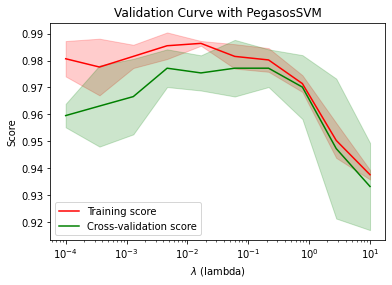

best lambda: 0.005
Cross-validation score: 0.977
Training score: 0.986


In [4]:
# Analyze the effect of the hyper parameter  𝜆  on your training and test error

np.random.seed(10)
param_range = np.logspace(-4, 1, 10)
train_scores, test_scores = validation_curve(ps_pipe, X, y, param_name="SVM__plambda", param_range=param_range, cv=5, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Validation Curve with PegasosSVM")
plt.xlabel("$\lambda$ (lambda)")
plt.ylabel("Score")
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()
best_val = np.max(test_scores_mean)
best_lam = param_range[np.argmax(test_scores_mean)]
train_score = train_scores_mean[np.argmax(test_scores_mean)]
print("best lambda:",round(best_lam,3))
print("Cross-validation score:",round(best_val,3))
print("Training score:",round(train_score,3))

We can see that the model performs better with small lambdas.

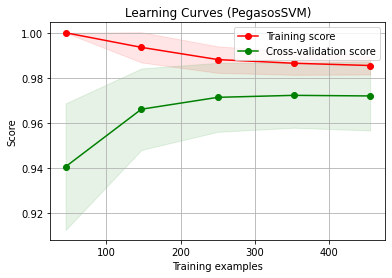

In [5]:
# Analyze the learning curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (PegasosSVM)"
                        
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
best_pipe = Pipeline([('Scaler', StandardScaler()),('SVM', PegasosSVM(plambda=best_lam))])
plot_learning_curve(best_pipe, title, X, y, cv=cv, n_jobs=4) 

plt.show()

We see that the cross validation score improves as the model receives more examples. Around 400 examples it stabilies so that can be a good samples amount (more examples may not improve it further)

In [6]:
# Bonus: Mini-batches

np.random.seed(10)
batches_pipe = Pipeline([('Scaler', StandardScaler()),('SVM', PegasosSVM(plambda=best_lam,k=10,T=1000))])
batches_scores = cross_val_score(batches_pipe, X, y, cv=5)    
print("Size 10 Mini Batches with 1000 iterations mean cross_val_score:",batches_scores.mean())

Size 10 Mini Batches with 1000 iterations mean cross_val_score: 0.971914299021891


We receive quite similar results when using 10 size mini batches with 1000 iterations and when not uning mini batches with 10000 iterations.

# 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this create a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

* For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

* Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

* repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


# Answer #

In [7]:
# create a function make_data which generates a two dimensional dataset with n_samples=1000 where a fraction imbalance=0.1 is
# labeled 0 and the rest 1. The distribution of  𝑥  given  𝑦=0  or  𝑦=1  is gaussian with std 0.5 or 2, respectively and that
# the centers are at  𝑥1=0  and  𝑥2=−𝑑/2  and  𝑥2=𝑑/2 ,

def make_data(d, imbalance=0.1):
    n_samples=1000
    X = np.zeros((n_samples, 2))
    y = np.random.binomial(1, 1-imbalance, n_samples)
    size_0 = np.sum(y==0)
    size_1 = np.sum(y==1)
    X[y==0,0] = np.random.normal(loc=0, scale=0.5, size=size_0)
    X[y==1,0] = np.random.normal(loc=0, scale=2, size=size_1)
    X[y==0,1] = np.random.normal(loc=-d/2, scale=0.5, size=size_0)
    X[y==1,1] = np.random.normal(loc=d/2, scale=2, size=size_1)
    return X, y

Text(0.5, 1.0, 'd = 2')

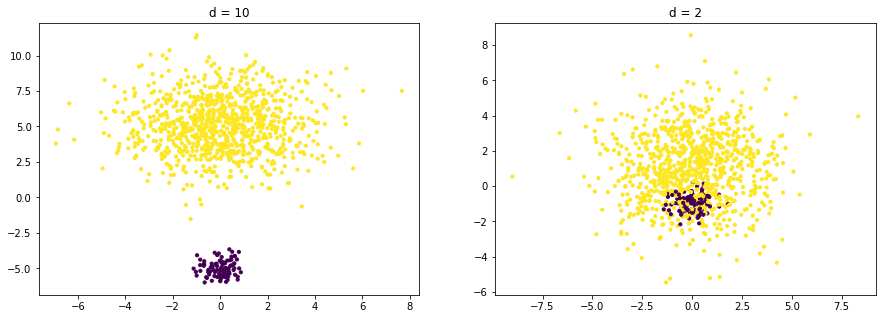

In [8]:
# For d=10 and d=2 plot the scatter plot of the data

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
X10, y10 = make_data(10)
ax1.scatter(X10[:,0],X10[:,1], c=y10, s=10)
ax1.set_title('d = 10')
X2, y2 = make_data(2)
ax2.scatter(X2[:,0],X2[:,1], c=y2, s=10)
ax2.set_title('d = 2')

#### Where would you think the SVM hyperplane will lie? ####
For d = 10 we expect a hyperplane at around x2 = -2.5

For d = 10 maybe at around 0

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 1.0, 'd = 2, accuracy = 0.9, balanced accuracy = 0.5')

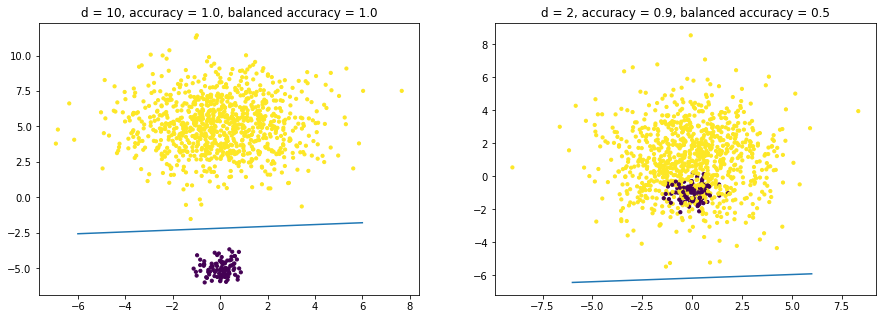

In [10]:
# for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.scatter(X10[:,0],X10[:,1], c=y10, s=10)
ax2.scatter(X2[:,0],X2[:,1], c=y2, s=10)

SVC10 = LinearSVC()
SVC10.fit(X10,y10)
w10 = SVC10.coef_[0]
a10= -w10[0] / w10[1]
xx10 = np.linspace(-6, 6)
yy10 = a10 * xx10 - (SVC10.intercept_[0]) / w10[1]
ax1.plot(xx10,yy10)
y10_pred = SVC10.predict(X10)
accuracy10 = accuracy_score(y10, y10_pred)
balanced_accuracy10 = balanced_accuracy_score(y10, y10_pred)
ax1.set_title(f'd = 10, accuracy = {accuracy10:.1f}, balanced accuracy = {balanced_accuracy10:.1f}')

SVC2 = LinearSVC()
SVC2.fit(X2,y2)
w2 = SVC2.coef_[0]
a2= -w2[0] / w2[1]
xx2 = np.linspace(-6, 6)
yy2 = a2 * xx2 - (SVC2.intercept_[0]) / w2[1]
ax2.plot(xx2,yy2)
y2_pred = SVC2.predict(X2)
accuracy2 = accuracy_score(y2, y2_pred)
balanced_accuracy2 = balanced_accuracy_score(y2, y2_pred)
ax2.set_title(f'd = 2, accuracy = {accuracy2:.1f}, balanced accuracy = {balanced_accuracy2:.1f}')

Text(0.5, 1.0, 'd = 2, accuracy = 0.7, balanced accuracy = 0.8')

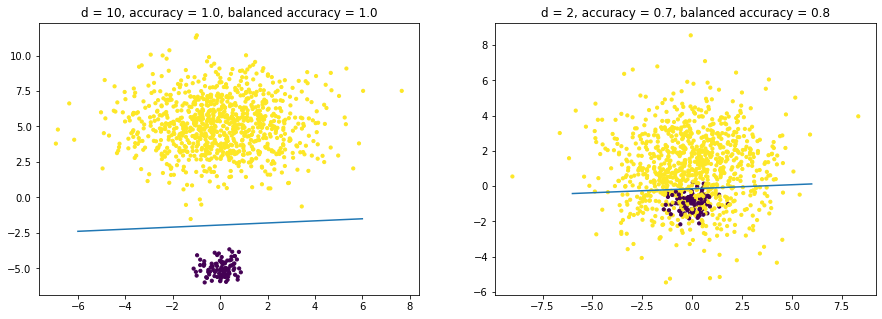

In [11]:
# repeat the experiment but now set the class_weight to be balanced

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.scatter(X10[:,0],X10[:,1], c=y10, s=10)
ax2.scatter(X2[:,0],X2[:,1], c=y2, s=10)

SVC10 = LinearSVC(class_weight='balanced')
SVC10.fit(X10,y10)
w10 = SVC10.coef_[0]
a10= -w10[0] / w10[1]
xx10 = np.linspace(-6, 6)
yy10 = a10 * xx10 - (SVC10.intercept_[0]) / w10[1]
ax1.plot(xx10,yy10)
y10_pred = SVC10.predict(X10)
accuracy10 = accuracy_score(y10, y10_pred)
balanced_accuracy10 = balanced_accuracy_score(y10, y10_pred)
ax1.set_title(f'd = 10, accuracy = {accuracy10:.1f}, balanced accuracy = {balanced_accuracy10:.1f}')

SVC2 = LinearSVC(class_weight='balanced')
SVC2.fit(X2,y2)
w2 = SVC2.coef_[0]
a2= -w2[0] / w2[1]
xx2 = np.linspace(-6, 6)
yy2 = a2 * xx2 - (SVC2.intercept_[0]) / w2[1]
ax2.plot(xx2,yy2)
y2_pred = SVC2.predict(X2)
accuracy2 = accuracy_score(y2, y2_pred)
balanced_accuracy2 = balanced_accuracy_score(y2, y2_pred)
ax2.set_title(f'd = 2, accuracy = {accuracy2:.1f}, balanced accuracy = {balanced_accuracy2:.1f}')

#### Explain what was the problem and how changing class weight solved it ####
When d = 2 the classes are not lineary separable. The inner class is very small compared to the other so while classifing the learer didn't pay enough attention to it and treated the 2 distributions as the same one. Balancing the classes weights made the learner recognize the 2 separate classes (still it can't separate them lineary).

# 3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.


# Answer #

In [ ]:
# check combinations of the hyper parameters

np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,)
SVC_pipe = Pipeline([('Scaler', StandardScaler()), ('SVC', LinearSVC())])
params = {'SVC__multi_class':['ovr', 'crammer_singer'],
            'SVC__loss':['hinge', 'squared_hinge'],
            'SVC__C': np.logspace(-3,3,10)}
grid = GridSearchCV(estimator=SVC_pipe, param_grid=params,n_jobs=-1)
grid.fit(X_train, y_train)
best_estimator = grid.best_estimator_
best_estimator

Pipeline(steps=[('Scaler', StandardScaler()),
                ('SVC',
                 LinearSVC(C=0.46415888336127775, loss='hinge',
                           multi_class='crammer_singer'))])

In [ ]:
# Compare the accuracy of the model to a default LinearSVC model with no hyper parameter optimization in terms of accuracy

best_m_accuracy = np.mean(cross_val_score(best_estimator, X_train, y_train, cv=5))
default_accuracy = np.mean(cross_val_score(SVC_pipe, X_train, y_train, cv=5))
print("Fitted model accuracy:", best_m_accuracy)
print("Default model accuracy:", default_accuracy)

if(best_m_accuracy > default_accuracy):
    print("Fitted model performs better")
    
else:
    print("Default model performs better")

Fitted model accuracy: 0.9802197802197803
Default model accuracy: 0.9736263736263737
Fitted model performs better


C:\Users\dana.LAPTOP-61I4GLAR\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


# 4. Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

